In [1]:
%matplotlib inline

import operator
import numpy
import matplotlib.pyplot as plt
from iris.analysis.cartography import rotate_pole
import cartopy.crs as ccrs

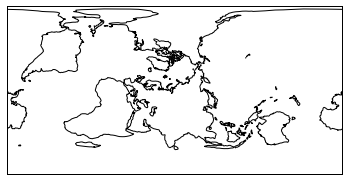

In [38]:
lons = numpy.arange(225, 340, 5)
lats = numpy.zeros(lons.shape)

plt.axes(projection=ccrs.RotatedPole(260, 20, central_rotated_longitude=0))

#plt.plot(lons, lats, transform=ccrs.RotatedGeodetic(260, 20))
#plt.plot(lons, lats, transform=ccrs.RotatedPole(pole_longitude=260, pole_latitude=20))

plt.gca().coastlines()
plt.show()

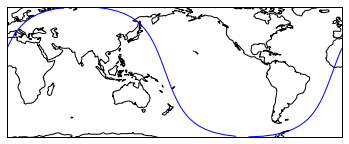

In [35]:
lons = numpy.arange(-180, 180, 5)
lats = numpy.zeros(lons.shape)

plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))

plt.plot(lons, lats, transform=ccrs.RotatedPole(pole_longitude=260, pole_latitude=20))
        
plt.gca().coastlines()
plt.show()